# Lab-03 Neural Networks

## Loading Data

In [1]:
import os
import re
import cv2

images = []
pose_name = []
images_path = []
images_pixels = []
labels = []

dict = {}

i=0
dataPath = './yogaData'

for directory in os.listdir(dataPath):
    dirPath = os.path.join(dataPath, directory)
    if os.path.isdir(dirPath):
        pose_name.append(directory)
        for img in os.listdir(dirPath):
            if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
                img_path = os.path.join(dirPath,img)
                images.append(img)
                images_path.append(img_path)
                img_pix = cv2.imread(img_path,1)
                images_pixels.append(cv2.resize(img_pix, (100,100)))
                labels.append(i)
        
    i = i+1
            
print("Total images: ", len(images))
print("Total images path: ", len(images_path))
print("Total postures: ", len(pose_name))
print("Total images_pixels: ", len(images_pixels))  

libpng warning: iCCP: known incorrect sRGB profile


Total images:  2177
Total images path:  2177
Total postures:  9
Total images_pixels:  2177


In [2]:
import pandas as pd

images_df = pd.DataFrame(images)
images_df # It appears to be a list of pictures in different file formats.


pose_name_df = pd.DataFrame(pose_name)
pose_name_df # A list of 8 possible yoga poses to classify. The target.

images_path_df = pd.DataFrame(images_path)
images_path_df # Directory path to all the files that are in the images list.

images_pixels # multi dimensional array of pixels. Higher than 2d.

labels_df = pd.DataFrame(labels)
labels_df # values 0-8 based on the 8 different yoga poses.

,0
0,0
1,0
2,0
3,0
4,0
...,...
2172,8
2173,8
2174,8
2175,8


In [3]:
import random

shuffled = list(zip(images_pixels,labels))
random.shuffle(shuffled)

train_data, labels_data = zip(*shuffled)

In [4]:
from tensorflow.keras.utils import to_categorical
import numpy as np

X_data = np.array(train_data)/255
Y_data =  to_categorical(labels_data, num_classes = 10)

2023-11-27 06:39:35.842357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 06:39:36.035348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 06:39:36.036496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 06:39:37.209013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


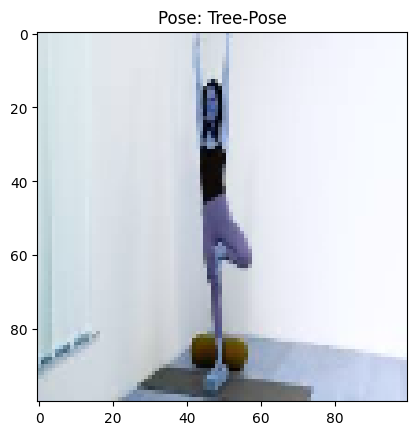

In [5]:
import matplotlib.pyplot as plt

index = random.randint(0, len(X_data) - 1) # Randomly select some image to plot
plot_image = X_data[index]

plt.imshow(plot_image)
plt.title(f'Pose: {pose_name[labels_data[index]]}')
plt.show()

## Split the Data

In [6]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

In [7]:
print("train_x shape:", train_x.shape)
print("val_X shape:", val_x.shape)
print("train_y shape:", train_y.shape)
print("val_y shape:", val_y.shape)

train_x shape: (1741, 100, 100, 3)
val_X shape: (436, 100, 100, 3)
train_y shape: (1741, 10)
val_y shape: (436, 10)


## Random Forest

In [8]:
nsamples, nx, ny, nrgb = train_x.shape
train_x_flattened = train_x.reshape((nsamples, nx * ny * nrgb))

nsamples_val, _, _, _ = val_x.shape
val_x_flattened = val_x.reshape((nsamples_val, nx * ny * nrgb))

In [9]:
print("train_x shape:", train_x_flattened.shape)
print("val_x shape:", val_x_flattened.shape)

train_x shape: (1741, 30000)
val_x shape: (436, 30000)


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    criterion='gini',           # The function to measure the quality of a split
    min_samples_split=2,        # The minimum number of samples required to split an internal node
    min_samples_leaf=1,         # The minimum number of samples required to be at a leaf node
    max_features='sqrt',        # The number of features when looking for the best split
    bootstrap=True,             # Whether bootstrap samples are used when building trees
    random_state=42             # Controls both the randomness of the bootstrapping of the samples 
                                # used when building trees and the sampling of the features to consider when looking for the best split at each node
)

In [11]:
rf.fit(train_x_flattened, train_y.argmax(axis=1))

RandomForestClassifier(random_state=42)

In [12]:
predict_y = rf.predict(val_x_flattened)

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(val_y.argmax(axis=1), predict_y)
print("Accuracy:", accuracy)

Accuracy: 0.676605504587156


In [14]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(val_y.argmax(axis=1), predict_y))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64        44
           1       0.72      0.66      0.69        59
           2       0.60      0.77      0.68        64
           3       0.65      0.78      0.71        50
           4       0.75      0.83      0.79        36
           5       0.73      0.65      0.69        46
           6       0.73      0.70      0.71        53
           7       0.66      0.45      0.54        42
           8       0.68      0.55      0.61        42

    accuracy                           0.68       436
   macro avg       0.68      0.67      0.67       436
weighted avg       0.68      0.68      0.67       436



In [15]:
# It looks like the predictions are some what accurate

## Convolutional Neural Network

### DataLoader

In [16]:
from torch.utils.data import DataLoader

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_sample = self.X[idx]
        y_sample = self.Y[idx]
        
        if self.transform:
            x_sample = self.transform(x_sample)
            
        return x_sample, y_sample

In [17]:
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
])

In [18]:
train_dataset = CustomDataset(train_x, train_y, img_transform)

In [19]:
val_dataset = CustomDataset(val_x, val_y, img_transform)

### Neural Network

In [20]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(train_dataset, batch_size=16)
valLoader = DataLoader(val_dataset, batch_size=16)

In [21]:
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # in channels: # colors in input image (grey = 1; color = 3)
            # out channels: # filters
            # kernel size: how big an area should we consider
            # stride: # of pixels to move the kernel over by
            # padding: # of pixels to add at each edge of image (3x3 kernel : padding = 1 ||
            #           5x5 kernel : padding = 2)
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = nn.Sequential(nn.Linear(10000, 10))

    def forward(self, X):
        X = X.float()
        output = self.cnn_layers(X)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [22]:
model = CNN()

In [23]:
import torch.optim as optim

optimiser = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [25]:
epochs = 35
epoch = 0
total_patience = 3
patience = total_patience
stop_training = False

prev_valid_loss = 500000.

while epoch < epochs and not stop_training:
    total_loss = 0.
    valid_loss = 0.

    # Train
    model.train()
    for images, labels in trainLoader:
        optimiser.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()


    print('Epoch', epoch, 'loss:', (total_loss / len(trainLoader)))

    epoch += 1

Epoch 0 loss: 1.5018828801058848
Epoch 1 loss: 1.2612677976625775
Epoch 2 loss: 1.0823331830698415
Epoch 3 loss: 0.935535450320725
Epoch 4 loss: 0.8107557266677191
Epoch 5 loss: 0.7037500744565911
Epoch 6 loss: 0.611688486479838
Epoch 7 loss: 0.5331204026390653
Epoch 8 loss: 0.46653902626365695
Epoch 9 loss: 0.4099260356721528
Epoch 10 loss: 0.36173404459286174
Epoch 11 loss: 0.32042427402023876
Epoch 12 loss: 0.285078674349763
Epoch 13 loss: 0.25537648721845874
Epoch 14 loss: 0.23080849975620935
Epoch 15 loss: 0.21043450624570934
Epoch 16 loss: 0.1935689950686529
Epoch 17 loss: 0.17951960530166233
Epoch 18 loss: 0.16788978372281843
Epoch 19 loss: 0.15841262625239858
Epoch 20 loss: 0.1505991939045147
Epoch 21 loss: 0.1441136059616137
Epoch 22 loss: 0.13810835848776026
Epoch 23 loss: 0.13222418621250795
Epoch 24 loss: 0.12641030917405535
Epoch 25 loss: 0.12156732882791703
Epoch 26 loss: 0.11684393002694353
Epoch 27 loss: 0.11244827874620027
Epoch 28 loss: 0.10912347856669798
Epoch 29 lo

In [26]:
# Validate
import torch
total = 0
correct = 0

model.eval()
for image, labels in valLoader:
    output = model(image)
    _, predicted = torch.max(output, 1)
    for i in range(len(labels)):
        pred = predicted[i]
        total+=1
        if labels[i][pred] == 1:
            correct += 1
print('Accuracy', float(correct) / float(total))

Accuracy 0.6559633027522935
